# Assignment 2
### Sean Harkin, 17364523

In [72]:
import pandas as pd
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Question 1: Rectify bias
I will explore the impact of SMOTE upsampling to reduce bias using hold-out testing and pipelines and cross validation.

### Upsampling
We can define a SMOTE instance with default parameters that will balance the minority class and then fit and apply it in one step to create a transformed version of our dataset. SMOTE produces additional synthetic minority class samples by interpolating between real samples.  
We configure SMOTE to bring up the minority class count level with the majority class. 

### Models
In this analysis I will use 4 different classifiers
- k-NN
- Decision Trees 
- Logistic Regression
- Gradient Boosting

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

model_d = {}

model_d['dtree'] = DecisionTreeClassifier(criterion='entropy')
model_d['kNN'] = KNeighborsClassifier(n_neighbors=3)  
model_d['gradientBoost'] = GradientBoostingClassifier()
model_d['logistic'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=0)


In [74]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [75]:
surv['Survived'].value_counts() 

GE5    225
L5      81
Name: Survived, dtype: int64

In [76]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

# Hold out testing

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [78]:
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [79]:
print("Original Training")
print("Majority class:",Counter(y_train)['GE5'])
print("Minority class:", Counter(y_train)['L5'])
print("Upsampled Training")
print("Majority class:",Counter(y_train_res)['GE5'])
print("Minority class:",Counter(y_train_res)['L5'])

Original Training
Majority class: 179
Minority class: 50
Upsampled Training
Majority class: 179
Minority class: 179


You can now see that we upsampled the minority class in the training data so that the training contains an even number of each class.

In [80]:
bias_d = {}
acc_d = {}


for m in model_d:
    y_pred = model_d[m].fit(X_train_res, y_train_res).predict(X_test)

    pred_neg = Counter(y_pred)['L5']
    test_neg = Counter(y_test)['L5']
    bias_d[m] = pred_neg/len(y_pred)
    
    print("{:22}".format(type(model_d[m]).__name__))
    print(X_train_res.shape,X_test.shape)
    print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
    acc_d[m] = accuracy_score(y_pred, y_test)
    print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
    print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))

DecisionTreeClassifier
(358, 3) (77, 3)
Accuracy:  0.56
Minority class in test set : 0.40
Predicted minority class : 0.38
KNeighborsClassifier  
(358, 3) (77, 3)
Accuracy:  0.64
Minority class in test set : 0.40
Predicted minority class : 0.32
GradientBoostingClassifier
(358, 3) (77, 3)
Accuracy:  0.62
Minority class in test set : 0.40
Predicted minority class : 0.26
LogisticRegression    
(358, 3) (77, 3)
Accuracy:  0.65
Minority class in test set : 0.40
Predicted minority class : 0.26


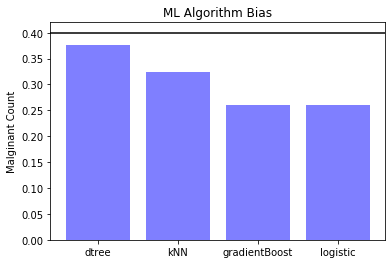

In [81]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive = list(bias_d.values())

y_pos = np.arange(len(objects))

plt.bar(y_pos, positive, align='center', color=['blue', 'blue','blue','blue'],alpha=0.5)
plt.axhline(y= round(test_neg/len(y_test),1), color='black', linestyle='-')
plt.xticks(y_pos, objects)
plt.ylabel('Malginant Count')
plt.title('ML Algorithm Bias')
 
plt.show()

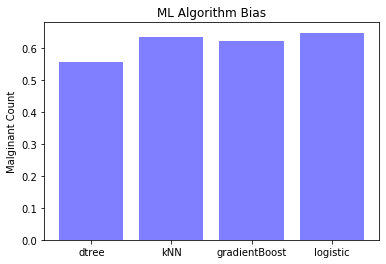

In [82]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive = list(acc_d.values())

y_pos = np.arange(len(objects))

plt.bar(y_pos, positive, align='center', color=['blue', 'blue','blue','blue'],alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Malginant Count')
plt.title('ML Algorithm Bias')
 
plt.show()

### Hold- Out Testing Discussion
The test set contained 40% L5 and 60% GE5.
- The assessment is unstable in that different runs produce different results.
- Assessment of bias is independent of accuracy, i.e. proportion of examples classified as the minority class compared with the actual proportion in the test set.
- Every model appears to be biased towards the majority class as each model predicts less than 40% L5 class.
- Logistic regression and gradient boosting showed the most bias, only predicting 26% L5 class.
- K-NN wasnt much better as it predicted 32% L5 class.
- Decision tree showed the least biased predicting 34% L5 class. Although this was the least biased it still is biased towards the majority class.

# Pipelines & Cross Validation

In [83]:
dtreepipe  = Pipeline(steps=[
    ('upsampler', SMOTE(random_state=0)),
    ('classifier',  DecisionTreeClassifier(criterion='entropy'))])

kNNpipe  = Pipeline(steps=[
    ('upsampler', SMOTE(random_state=0)),
    ('classifier', KNeighborsClassifier(n_neighbors=3))])

gradientBoostpipe  = Pipeline(steps=[
    ('upsampler', SMOTE(random_state=0)),
    ('classifier', GradientBoostingClassifier())])

logisticpipe  = Pipeline(steps=[
    ('upsampler', SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=10000, solver = 'sag', random_state=0))])

In [84]:
model_d = {}

model_d['dtree'] = dtreepipe 
model_d['kNN'] = kNNpipe  
model_d['gradientBoost'] = gradientBoostpipe
model_d['logistic'] = logisticpipe


In [85]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

v = 0 #  use 1 or 0

In [86]:
folds = 3
bias_cvx3 = {}
acc_cvx3 = {}
for m in model_d:
    cv_results = cross_validate(model_d[m], X, y, cv= folds,scoring=scoring, return_train_score=False,verbose = v, n_jobs = -1)
    p_tot = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tn'].sum() + cv_results['test_tp'].sum())/len(y)
    bias_cvx3[m] = p_tot
    acc_cvx3[m] = acc
    
    print("{} x CV {:22} N: {:d} Pred N: {:d} Acc: {:.2f}".format(folds, type(model_d[m]).__name__, 81 , p_tot,acc)) 

3 x CV Pipeline               N: 81 Pred N: 107 Acc: 0.60
3 x CV Pipeline               N: 81 Pred N: 93 Acc: 0.65
3 x CV Pipeline               N: 81 Pred N: 94 Acc: 0.64
3 x CV Pipeline               N: 81 Pred N: 151 Acc: 0.58


In [87]:
folds = 5
bias_cvx5 = {}
acc_cvx5 = {}
for m in model_d:
    cv_results = cross_validate(model_d[m], X, y, cv= folds,scoring=scoring, return_train_score=False,verbose = v, n_jobs = -1)
    p_tot = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tn'].sum() + cv_results['test_tp'].sum())/len(y)
    bias_cvx5[m] = p_tot
    acc_cvx5[m] = acc
    
    print("{} x CV {:22} N: {:d} Pred N: {:d} Acc: {:.2f}".format(folds, type(model_d[m]).__name__, 81 , p_tot,acc)) 

5 x CV Pipeline               N: 81 Pred N: 73 Acc: 0.62
5 x CV Pipeline               N: 81 Pred N: 103 Acc: 0.64
5 x CV Pipeline               N: 81 Pred N: 88 Acc: 0.62
5 x CV Pipeline               N: 81 Pred N: 102 Acc: 0.72


In [88]:
folds = 10
bias_cvx10 = {}
acc_cvx10 = {}
for m in model_d:
    cv_results = cross_validate(model_d[m], X, y, cv= folds,scoring=scoring, return_train_score=False,verbose = v, n_jobs = -1)
    p_tot = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tn'].sum() + cv_results['test_tp'].sum())/len(y)
    bias_cvx10[m] = p_tot
    acc_cvx10[m] = acc
    
    print("{} x CV {:22} N: {:d} Pred N: {:d} Acc: {:.2f}".format(folds, type(model_d[m]).__name__, 81 , p_tot,acc)) 

10 x CV Pipeline               N: 81 Pred N: 109 Acc: 0.62
10 x CV Pipeline               N: 81 Pred N: 113 Acc: 0.62
10 x CV Pipeline               N: 81 Pred N: 126 Acc: 0.57
10 x CV Pipeline               N: 81 Pred N: 83 Acc: 0.74


In [89]:
for key in bias_cvx3:
    bias_cvx3[key]= bias_cvx3[key]/len(y)
    
for key in bias_cvx5:
    bias_cvx5[key]= bias_cvx5[key]/len(y)
    
for key in bias_cvx10:
    bias_cvx10[key]= bias_cvx10[key]/len(y)

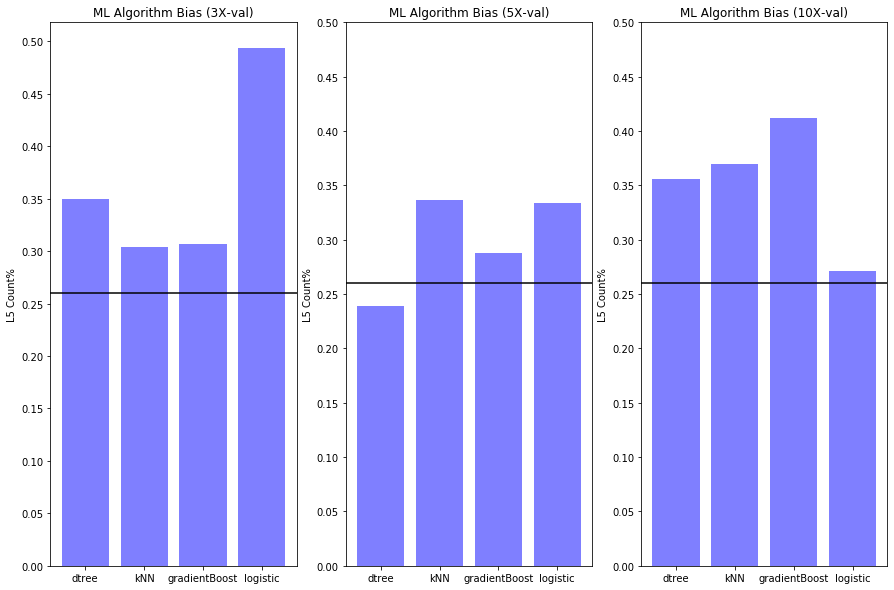

In [90]:
objects = list(bias_cvx3.keys())
positivex3 = list(bias_cvx3.values())
positivex5 = list(bias_cvx5.values())
positivex10 = list(bias_cvx10.values())

fig, ax = plt.subplots(figsize=(15,10))
y_pos = np.arange(len(objects))
plt.subplot(1, 3, 1)
plt.bar(y_pos, positivex3, align='center', color=['blue', 'blue','blue','blue','blue'],alpha=0.5)
plt.axhline(y= round(Counter(y)['L5']/len(y),2), color='black', linestyle='-')
plt.yticks([0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,00.40,0.45,0.50])
plt.xticks(y_pos,objects)
plt.ylabel('L5 Count%')
plt.title('ML Algorithm Bias (3X-val)')

plt.subplot(1, 3, 2)
y_pos = np.arange(len(objects))

plt.bar(y_pos, positivex5, align='center', color=['blue', 'blue','blue','blue','blue'],alpha=0.5)
plt.axhline(y= round(Counter(y)['L5']/len(y),2), color='black', linestyle='-')
plt.yticks([0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,00.40,0.45,0.50])
plt.xticks(y_pos,objects)
plt.ylabel('L5 Count%')
plt.title('ML Algorithm Bias (5X-val)')

plt.subplot(1, 3, 3)
y_pos = np.arange(len(objects))

plt.bar(y_pos, positivex10, align='center', color=['blue', 'blue','blue','blue','blue'],alpha=0.5)
plt.axhline(y= round(Counter(y)['L5']/len(y),2), color='black', linestyle='-')
plt.yticks([0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,00.40,0.45,0.50])
plt.xticks(y_pos,objects)
plt.ylabel('L5 Count%')
plt.title('ML Algorithm Bias (10X-val)')
 
plt.show()

### X-Val Testing Discussion
- In general, 5 fold cross validation seems to produce the best results.
- This assessment is more robust than Hold-Out Testing because all data is consisered. 
  - We have 81 minority class examples compared with 31 (40% of the test set) in hold-out.
- Gradient boosting and Decision trees are not really showing any bias in both 10 and 5 fold cross validation.

# Hold Out and Cross Validation compared

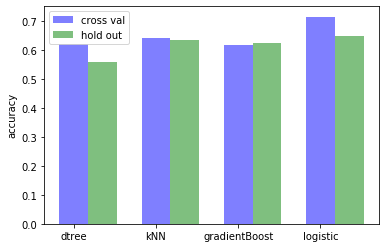

In [91]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

fig, ax = plt.subplots()
width = 0.35

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive =list(acc_cvx5.values())
res = list(acc_d.values())

y_pos = np.arange(len(objects))

p1 = ax.bar(y_pos, positive, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)

p2 = ax.bar(y_pos+width, res, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)

ax.legend((p1[1], p2[1]), ('cross val', 'hold out'))

plt.xticks(y_pos, objects)
plt.ylabel('accuracy')

 
plt.show()

### Hold Out and X Val - Discussion
 
- In this graph you can see that Cross validation had a higher acurracy than hold out for 3 models (dtree, kNN and logistic regression)
- The assessment is unstable in that different runs produce slightly different results. 

As this assessment is unstable, I will perform analysis to show how X Val estimates of accuracy are lower variance that Hold Out. This is done by repeating each analysis 100 times and plotting the results. 

# Hold Out testing

In [92]:
reps = 100
dtreeho=[]
for i in range(reps):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    y_pred = dtreepipe.fit(X_train_res, y_train_res).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    dtreeho.append(acc)

In [93]:
kNNho=[]
for i in range(reps):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    y_pred = kNNpipe.fit(X_train_res, y_train_res).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kNNho.append(acc)

In [94]:
gradientBoostho=[]
for i in range(reps):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    y_pred = gradientBoostpipe.fit(X_train_res, y_train_res).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    gradientBoostho.append(acc)

In [95]:
logisticho=[]
for i in range(reps):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    y_pred = logisticpipe.fit(X_train_res, y_train_res).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    logisticho.append(acc)

# X Val

In [96]:
dtreexv = []
for i in range(reps):
    kf=KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(dtreepipe, X, y, cv=kf)
    dtreexv.append(scores.mean())

In [97]:
kNNxv = []
for i in range(reps):
    kf=KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(kNNpipe, X, y, cv=kf)
    kNNxv.append(scores.mean())

In [98]:
gradientBoostxv = []
for i in range(reps):
    kf=KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(gradientBoostpipe, X, y, cv=kf)
    gradientBoostxv.append(scores.mean())

In [99]:
logisticxv = []
for i in range(reps):
    kf=KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(logisticpipe, X, y, cv=kf)
    logisticxv.append(scores.mean())

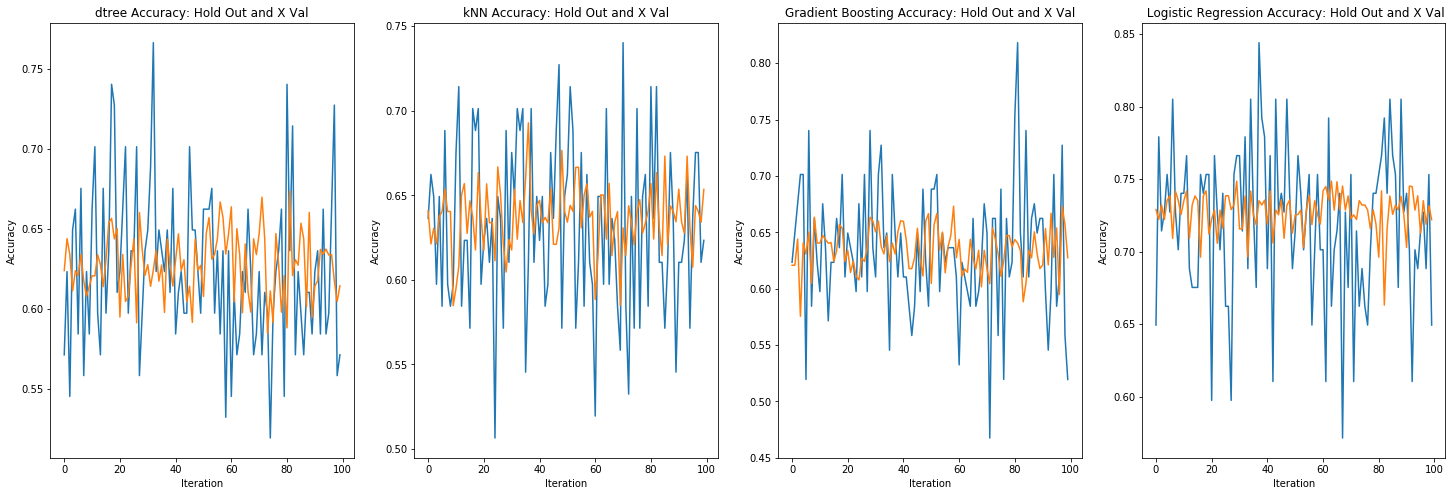

In [100]:
fig, ax = plt.subplots(figsize=(25,8))


plt.subplot(1, 4, 1)
res = pd.DataFrame(dtreeho, columns = ['Hold Out'])
res['X Val']=dtreexv
plt.plot(res)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("dtree Accuracy: Hold Out and X Val")


plt.subplot(1, 4, 2)
res = pd.DataFrame(kNNho, columns = ['Hold Out'])
res['X Val']=kNNxv
plt.plot(res)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("kNN Accuracy: Hold Out and X Val")


plt.subplot(1, 4, 3)
res = pd.DataFrame(gradientBoostho, columns = ['Hold Out'])
res['X Val']=gradientBoostxv
plt.plot(res)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Gradient Boosting Accuracy: Hold Out and X Val")


plt.subplot(1, 4, 4)
res = pd.DataFrame(logisticho, columns = ['Hold Out'])
res['X Val']=logisticxv
plt.plot(res)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title(" Logistic Regression Accuracy: Hold Out and X Val")

plt.show()

### Hold Out and X Val - Discussion
 
- For each model, X Val estimates of accuracy are lower variance that Hold Out.
- Hold Out estimates of accuaracy can be very high or very low.
- X Val estimates of accuracy vary, but not by much
- Cross validation testing is much more robust, especially when dealing with a small amount of training data.

### Final Conclusion
Generally, cross-validation is preferred over holdout. It's considered to be more robust, and accounts for more variance between possible splits in training, test, and validation data.
Models may be sensitive to the data used to train them. A small change in the training dataset could result in an extreme difference in the resulting model. Cross-validation can account for this by running multiple iterations of data splits, and averaging the performance together. The final model uses all of the available training data instead of a fraction of the training data as in hold out, which is also a benefit. 
A limitation of cross-validation is that it is more time consuming than the simple holdout method. Cross-validation effectively needs to repeat the method of training and testing a model for each iteration. If you have a huge dataset where each target variable is well represented, holding out a validation and test data set may work well and save you a lot of time in processing. However, cross-validation is widely considered to be a better, more robust approach to model evaluation as long as it is applied correctly. 
One thing to be careful of when using cross-validation (or even the holdout method) is having duplicate records in your dataset, where multiple rows (observations) have the same predictor and target variable values as one another. This will make cross-validation (or the test dataset) ineffective because if one or more of the duplicated records are left in the test dataset, the model will be able to predict that records with unrealistic accuracy. This can happen when you perform upsampling on your dataset to correct for an imbalanced class in your target variable. This is why we used a pipeline with cross validation. 

# Question 2: Feature Selection
I will assess the impact of feature selection on training and test datasets.

### Model
In this analysis I will use a single classifier
- Gradient Boosting

In [139]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

In [140]:
df_train = pd.read_csv('heart-train.csv')
print(df_train.shape)
df_train.head()

(199, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250,0
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209,0
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95,1
3,45.0,0,582,0,35,0,385000.00,1.00,145,1,0,61,1
4,72.0,0,127,1,50,1,218000.00,1.00,134,1,0,33,0


In [141]:
df_test = pd.read_csv('heart-test.csv')
print(df_test.shape)
df_test.head()

(100, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,95.0,1,112,0,40,1,196000.00,1.0,138,0,0,24,1
1,44.0,0,582,1,30,1,263358.03,1.6,130,1,1,244,0
2,68.0,1,220,0,35,1,289000.00,0.9,140,1,1,20,1
3,55.0,0,47,0,35,1,173000.00,1.1,137,1,0,79,0
4,60.0,0,68,0,20,0,119000.00,2.9,127,1,1,64,1


In [142]:
l = [df_train, df_test]
overall = pd.concat(l)
print(overall.shape)

(299, 13)


In [143]:
y_train = df_train.pop('DEATH_EVENT').values
X_train = df_train.values

In [144]:
y_test = df_test.pop('DEATH_EVENT').values
X_test = df_test.values

In [145]:
acc_arr = cross_val_score(gb, X_train, y_train, cv=5, n_jobs = -1)
print("Training Aaccuracy: {0:4.2f}".format(sum(acc_arr)/len(acc_arr)))

Training Aaccuracy: 0.78


In [146]:
y_pred = gb.fit(X_train, y_train).predict(X_test)
print('Test accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
original_acc = accuracy_score(y_pred, y_test)

Test accuracy:  0.82


## Filter method

In [180]:
mi = dict()

i_scores = mutual_info_classif(X_train, y_train)
for i,j in zip(df_train.columns,i_scores):
    mi[i]=j

df = pd.DataFrame.from_dict(mi,orient='index',columns=['I-Gain'])
df.sort_values(by=['I-Gain'],ascending=False,inplace=True)
df.head(15)

,I-Gain
time,0.219305
ejection_fraction,0.116933
serum_creatinine,0.075988
age,0.052777
smoking,0.043342
serum_sodium,0.035236
sex,0.012003
diabetes,0.011965
creatinine_phosphokinase,0.004049
anaemia,0.000000


In [181]:
acc_scores = []
for kk in range(1, X_train.shape[1]+1):
    FS_trans = SelectKBest(mutual_info_classif,k=kk).fit(X_train, y_train)
    X_tR_new = FS_trans.transform(X_train)
    X_tS_new = FS_trans.transform(X_test)
    acc_arr = cross_val_score(gb, X_tR_new, y_train, cv=10, n_jobs = -1)
    acc = sum(acc_arr)/len(acc_arr)
    acc_scores.append(acc)

df['Accuracy'] = acc_scores
df.head(10)

,I-Gain,Accuracy
time,0.219305,0.809474
ejection_fraction,0.116933,0.774737
serum_creatinine,0.075988,0.794474
age,0.052777,0.769474
smoking,0.043342,0.774474
serum_sodium,0.035236,0.759474
sex,0.012003,0.789474
diabetes,0.011965,0.789211
creatinine_phosphokinase,0.004049,0.794737
anaemia,0.000000,0.804737


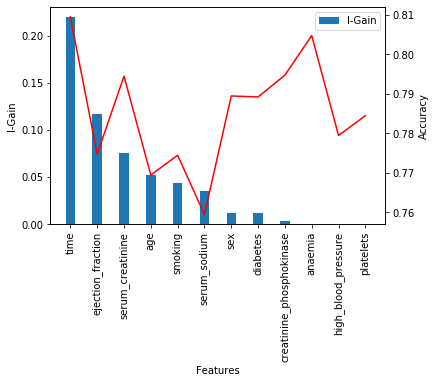

In [182]:
import matplotlib.pyplot as plt
%matplotlib inline

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax2.plot(df.index, df["Accuracy"], color='red', label='Accuracy')
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
ax.legend()

plt.show()

In [183]:
feature = df_train.columns
feature = list(feature)

In [184]:
maxA=df['Accuracy'].iloc[0]
for a in df['Accuracy']:
    if a>maxA:
        maxA=a
print("Maximum Accuracy:  ")
print(maxA)
c=0
for i in df['Accuracy']:
    c=c+1
    if maxA==i:
        break
print("Number of features needed: ")
print(c)

Maximum Accuracy:  
0.8094736842105263
Number of features needed: 
1


In [185]:
filter_features=df.index
filter_features=filter_features[:c]
list(filter_features)

['time']

In [186]:
for element in list(list(filter_features)):
    if element in feature:
        feature.remove(element)
        

new_df_train = df_train.drop(feature, axis=1)
new_df_test = df_test.drop(feature, axis=1)
new_X_train = new_df_train.values
new_X_test = new_df_test.values

In [187]:
y_pred = gb.fit(new_X_train, y_train).predict(new_X_test)
print('Test accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
filter_acc = accuracy_score(y_pred, y_test)

Test accuracy:  0.81


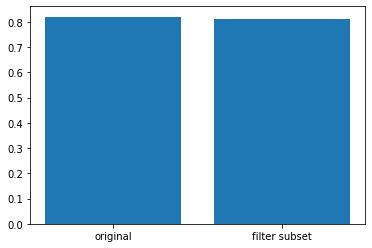

In [179]:
height = [original_acc, filter_acc]
bars = ('original', 'filter subset')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()


### Information gain Filter - Discussion
 
- The assessment is unstable in that different runs produce slightly different results. 
- Sometimes the test accuracy is improved by using the feature subset and other times the test accuracy decreases.

overall, I feel that this is a good method of feature selection however it is too unstabe for a dataset of this size.

## forward sequetial selection

In [201]:
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [202]:
feature = df_train.columns
feature

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')

In [203]:
sfs_forward = SFS(gb, 
                  k_features=len(feature), 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train,custom_feature_names=feature_names)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.4s finished
Features: 1/12[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.3s finished
Features: 2/12[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished
Features: 3/12[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.0s finished
Features: 4/12[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished
Features: 5/12[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.7s finished
Features: 6/12[Parallel(n_jobs=-1)]: Using backe

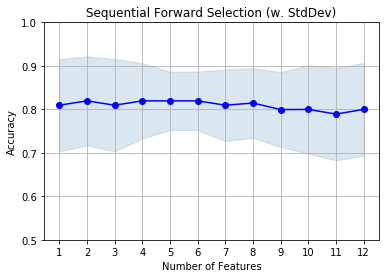

('age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time')


In [206]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
print(sfs_forward.k_feature_names_)

The results change each iteration however a subset containing 4 features seems to produce the best accuracy most iterations so I will let k_features equal 4 and runt his algorithm again.

In [207]:
sfs_forward = SFS(gb, 
                  k_features=4, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train,custom_feature_names=feature_names)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.9s finished
Features: 1/4[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.3s finished
Features: 2/4[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished
Features: 3/4[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.1s finished
Features: 4/4

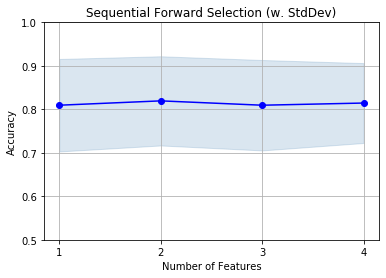

('anaemia', 'platelets', 'smoking', 'time')


In [208]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
print(sfs_forward.k_feature_names_)

In [209]:
feature = list(feature)
for element in list(list(sfs_forward.k_feature_names_)):
    if element in feature:
        feature.remove(element)
        

new1_df_train = df_train.drop(feature, axis=1)
new1_df_test = df_test.drop(feature, axis=1)
new1_X_train = new1_df_train.values
new1_X_test = new1_df_test.values

In [210]:
y_pred = gb.fit(new1_X_train, y_train).predict(new1_X_test)
print('Test accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
wrapper_acc = accuracy_score(y_pred, y_test)

Test accuracy:  0.82


In [211]:
sfs_backward = SFS(gb, 
                  k_features=len(feature_names), 
                  forward=False, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_backward = sfs_backward.fit(X_train, y_train,custom_feature_names=feature_names)

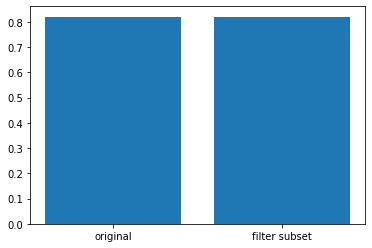

In [212]:
height = [original_acc, wrapper_acc]
bars = ('original', 'filter subset')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()


### Wrapper - Discussion
 
- The assessment is unstable in that different runs produce slightly different results. 
- It does seem to produce more stable results than the filter method used earlier.

overall, I feel that this is a good method of feature selection however it is too unstabe for a dataset of this size.

In [213]:
wrapper_features = set(list(sfs_forward.k_feature_names_))
intersection = wrapper_features.intersection(list(filter_features))

intersection_as_list = list(intersection)

print(intersection_as_list)

['time']


### Final conclusion
Overall, both methods of feature selection didnt really help improve our accuracy on the test set. Sometimes the accuracy was improved and others it was disimproved. The “stability” of a feature selection algorithm refers to the robustness of its feature preferences, with respect to data sampling and to its stochastic nature. Stability has been a major problem for feature selection methods. The dataset used in this example was very small, thus the feature section methods struggles to produce stable results.

Altough both feature selection methods didnt produce overall consistent results, the feature 'time' did seem to always be in the feature subset selected by both methods, thus, I belevie its fair to conclude that 'time' is an important feature for obtaining good accuracy.